<a href="https://colab.research.google.com/github/asotjrs/Deep-learning-with-pytorch/blob/main/Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Custom datasets with PyTorch

In [ ]:
import torch
from torch import nn

In [ ]:
#setup a device agnostic  code 
device= "cuda" if torch.cuda.is_available() else "cpu"
device 

'cuda'

## 1.Get the data
our dataset is a subset of food 101 dataset.
Food101 is a 101 different classes of food and 1000 images per class (750 training and 250 testing)

our dataset starts with 3 different classes of food  and only 10% of images(75 training , 25 testing)


why do this ?

when starting out ML projects, its important to try things on small scale and then increase the scale when necessary.

The whole point is to speed up how fast  you can experiment.


In [ ]:
import requests
import zipfile
from pathlib import Path
#setup path to data folder
data_path =Path('data/')
image_path=data_path/"pizza_steak_sushi"
#if the image folder doesn't exist, download it and prepare it ...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping downoald")
else:
  print(f"{image_path} does not exist, creating one ....")
  image_path.mkdir(parents=True,exist_ok=True)
#download pizza steak suqhi  data
with open(data_path/"pizza_steak_sushi.zip","wb")as f:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza steak sushi .....")
  f.write(request.content)
  #unzip pizza steak  sushi data 
  with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("unzipping pizza steak and sushi data .... ")
    zip_ref.extractall(image_path)



data/pizza_steak_sushi does not exist, creating one ....
unzipping pizza steak and sushi data .... 


##2.Becoming one with the Data (Data preparation and data exploration)


In [ ]:
import os
def walk_through_dir(dir_path):
  """Walk through dir_path returning its content"""
  for dirpath, dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [ ]:
#setup train and test paths
train_dir=image_path/"train"
test_dir=image_path/"test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#2.1Visualizing an image
lets write some code to :
1. get all of the images path
2. pick a random image path using Python's random.choice()
3. get the image class name using `pathlib.Path.parent.stem`
4. since we are working with images, let's open the image with Python's PIL
5. we'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/test/pizza/648055.jpg
Image class: pizza
image height 512
image width: 512


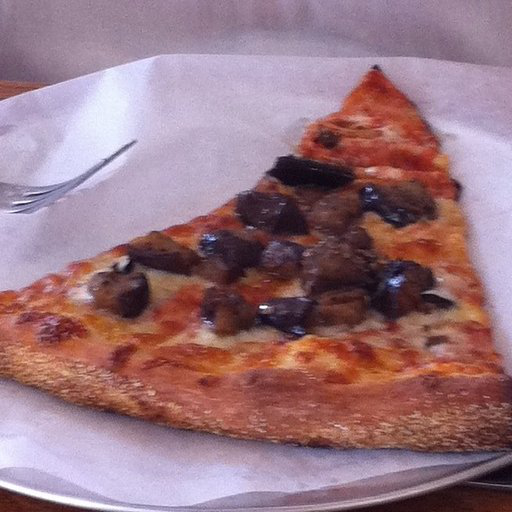

In [ ]:
import random
from PIL import Image
#Set seed 
random.seed(42)
#1.Get all images paths
image_path_list =list(image_path.glob("*/*/*.jpg"))
#pick a random image path
random_image_path=random.choice(image_path_list)
#get the image class from the path name(the image class is the name of the directory where theimage is stored)
image_class=random_image_path.parent.stem
#open image
img=Image.open(random_image_path)

#5.print meta data
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'image height {img.height}')
print(f'image width: {img.width}')
img

(-0.5, 511.5, 511.5, -0.5)

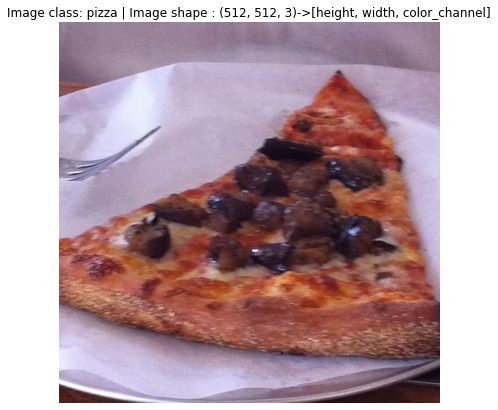

In [ ]:
#try to visualize my images with matplotlib
import numpy as np
import matplotlib.pyplot as plt
#turn the image into array
img_as_array =np.asarray(img)
#plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape : {img_as_array.shape}->[height, width, color_channel]')
plt.axis(False)

#3. Transforming data
we need to:
1. turn it into tensors
2. TURN IT TO `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader` 

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms  
 

#3.1 Transforming data with `torchvision.transforms
 -transforms help you get your images ready to be used with a model perform data augmentation

In [ ]:
#write a transform for image
data_transform=transforms.Compose(
    [
     #resize the image to 64x64
     transforms.Resize(size=(64,64)),
     #Flip the images randomly on the horizontal 
     transforms.RandomHorizontalFlip(p=0.5),
     #turn the image into torch.Totensor
     transforms.ToTensor()

    ]
)

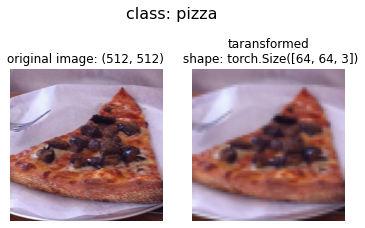

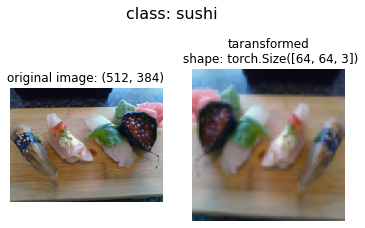

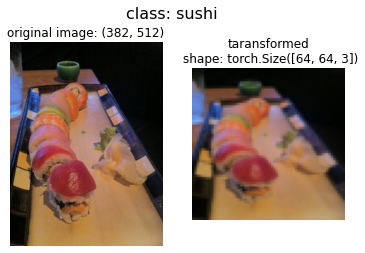

In [ ]:
def plot_transformed_images(image_paths:list,transform, n=3,seed=None):
  """
      Selects random imagesfrom a path of images and loads/transforms them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
    random_image_paths=random.sample(image_paths,k=n)
    for image_path in random_image_paths:
      with Image.open(image_path) as f:
        fig,ax=plt.subplots(nrows=1,ncols=2)
        ax[0].imshow(f)
        ax[0].set_title(f'original image: {f.size}')
        ax[0].axis(False)
      #Transform and lot our target image
      transformed_image =transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"taransformed\n shape: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f'class: {image_path.parent.stem}',fontsize=16)
plot_transformed_images(image_paths=image_path_list,transform=data_transform, n=3, seed=42)



##4.1 Loading image data using `ImageFolder`
we can load image clasification data using :`torchvision.datasets.ImageFolder`

In [ ]:
#Use ImageFolder to create a dataset(s)
from torchvision import datasets
train_data= datasets.ImageFolder(root=train_dir,
                                 transform=data_transform, #a transform for the data
                                 target_transform=None
                                 )
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
#Get class names as list
class_names =train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
#get class names as dict
class_dict=train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


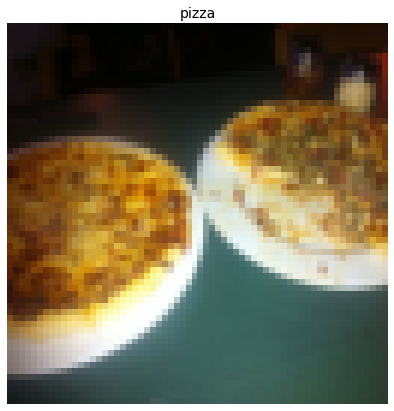

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

#4.1 turn oaded images into Dataloader s
a dataloader is going to help us turn our Dataset 's into iterable and we can customize the `batch_size` so our model can see `batch_size` images at a time

In [ ]:
#Turn our train and test dataasets into Dataloader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader =DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=True)
test_dataloader= DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            num_workers=1,
                            shuffle=False)

train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7f37126066a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3712606580>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img,label = next(iter(train_dataloader))
#Batch size now will be 1 , you can change the batch size if you like 
print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f'label shape: {label.shape}')

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
label shape: torch.Size([1])


#5.Option2 Loading image data with custom `Dataset`
1. want to be able to load images from file
2. want to be able to get class names from Dataset
3. want to be able to get classes as dictionary from datasets

Pros: 
* cancreate  a dataset out of almost anything
* Not limited to pytorch  pre build dataset functions

Cons:
* Even though you could create a dataset out of almost anything , it doesn't mean it will work
* using custom dataset often results in us writing more code, wich could be prone to errorsor performance issues

In [ ]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
#Instance of torchvision.datasets.ImageFolder()

#5.1 creating a helper function to get class names 
We want a function to:
1. Get the class names using  `os.scandir()` to traverse a target directory (ideally the directory is standard image classification format).
2. raise an error  if the class names aren't found (if this happens, there might be something wrong with the directory structure)
3. turn the class names into a dict and list and return them


In [ ]:
#Setup path for target directory
target_directory=train_dir
#get the class names from target directory
classes=sorted([entry.name for entry in list(os.scandir(target_directory))])
 

In [ ]:
def find_classes(directory:str) ->Tuple[List[str],Dict[str,int]]:
  """
  find the folder names in a target directory.
  """
  #get the class names by scanning the target directory
  classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  #raise an error if class names could not be found 
  if not classes:
    raise FileNotFoundError(f'Could not find any classes in {directory} ... Please check the file stucture.')

  #3. Create a dictionary of index labels (computer prefer number  rather than strings as labels)
  class_to_idx ={class_name: i for i,class_name in enumerate(classes)}

  return classes, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#5.2 Create a custom dataset to replicate image folder

to create our own dataset we want to: 
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with atarget directory(the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
 * paths(paths of our images)
 * transform -the transform we'd like to use
 * classes - a list of the target classes
 * class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to load images `load_images()` 
5. overwrite  the `__len__()` method to return the lebnght of our dataset
6. overwrite the `__getItem__()` method to return a given sample when passed an index


In [ ]:
#write a custom dataset class 
from torch.utils.data import Dataset

#1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #initialize our custom dataset
  def __init__(self, targ_dir:str, transform=None):
    #3. create class attributes
    #get all of the image paths
    self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    #setup transform
    self.transform=transform
    #Create classes and class_to_idx attributes
    self.classes , self.class_to_idx =find_classes(targ_dir)
  #4 create a function to load images
  def load_image(self, index:int)-> Image.Image:
    """
        opens an image via path and return it.
    """
    image_path =self.paths[index]
    return Image.open(image_path)
  #5 overwrite __len__()
  def __len__(self)->int:
    """
        return  the total number of samples
    """
    return len(self.paths)
  #6. overwrite the __getitem__() method to return a particular sample
  def __getitem__(self,index:int)-> Tuple[torch.Tensor,int]:
    """
      returns one sample of data and label (X,y).
    """
    img=self.load_image(index)
    class_name=self.paths[index].parent.name #expects path in format : data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]
    #transform if necessary
    if self.transform:
      return self.transform(img),class_idx #return data ,label (X,y)
    else:
      return img,class_idx  #return untransformed imagesand labels



In [ ]:
#create a transform
from torchvision import transforms
train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
 #Test out ImageFolderCustom
train_data_custom=ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transforms
)

test_data_custom=ImageFolderCustom(
    targ_dir=test_dir,
    transform=test_transforms
)


In [ ]:
train_data_custom , test_data_custom

(<__main__.ImageFolderCustom at 0x7f3712600070>,
 <__main__.ImageFolderCustom at 0x7f37125f3190>)

In [ ]:
test_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
#check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes==train_data.classes) 

True


##5.3 creaye a function to display random images
1. Take in a `Dataset` and a number of parameters such as class names and many images to visualize.
2. to prevent the display getting outta hand , let's cap the number of images to see at 10.
3. set the random seed for reproducibility
4. get a list of random sample indexes from the target dataset.
5. setup a matplotlib plot
6. loop through the random sample images and plot them with matplotlib.
7. make sure the dimentions of our images line up with matplotlib (HWC)

In [ ]:
# 1. take in a Dataset as well as a list of class names
def display_random_images(
    dataset: torch.utils.data.dataset.Dataset,
    classes: List[str]=None,
    n:int=10,
    display_shape:bool=True,
    seed:int=None):
  #2.adjust display if n is too high
  if n>10:
    n=10
    display_shape=False
    print(f" for display purposes n shouldn't be larger than 10, setting to 1à removing shape display")
  #3. set the random seed
  if seed:
    random.seed(seed)
  #4.get sample indexes
  random_samples_idx=random.sample(range(len(dataset)),k=n)
  #5. setup a plot 
  plt.figure(figsize=(15,8))
  #loop through random samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image,targ_label=dataset[targ_sample][0],dataset[targ_sample][1]
    #Adjust an image tensor shape for plotting: [color_channel,height,width]
    targ_image_adjust =targ_image.permute(1,2,0)

    #plot adjusted samples
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes: 
      title=f'class: {classes[targ_label]}'
      if display_shape:
        title=title+f'\n shape: {targ_image_adjust.shape} '
    plt.title(title)



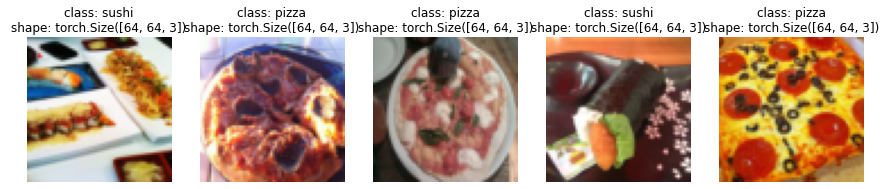

In [ ]:
#display random images from the ImageFolder  Dataset
display_random_images(train_data,n=5,classes=class_names,seed=42)

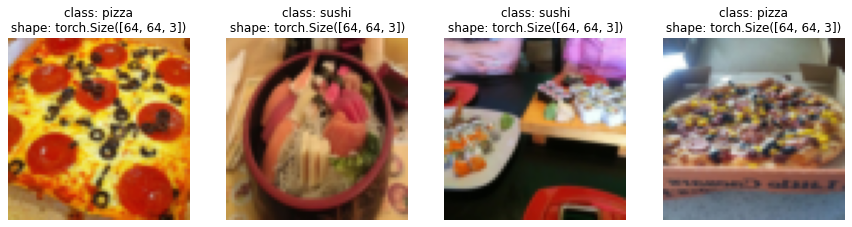

In [ ]:
#display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, n=4,classes=class_names,seed=42)

#5.4turn custom loaded images to DataLoaders

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader_custom =DataLoader(
    dataset=train_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True)
test_dataloader_custom=DataLoader(
    dataset=test_data_custom,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False)
train_dataloader_custom,test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7f371203d0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f371203d4c0>)

In [ ]:
#get image and label from custom dataloader
img_custom,label_custom=next(iter(train_dataloader_custom))
#print out the shape
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

##6 Other forms of transforms (data augmentation)
Data augmentation is the process of artificially adding diversity to your training data.

in the case of image data, this may mean applying  various image transformatios to training images.

this practise helpfully results in a model thats more generalizable to unseen data.

let's take a look at one particular type of data augmentation used to train pytorch vision models to state of the art


In [ ]:
#lets look at trivial augment
from torchvision import transforms
train_transform=transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor( )
])
test_transform=transforms.Compose([
    transforms.Resize(size=(244,244)),
    transforms.ToTensor()
])


In [ ]:
#get all image paths
image_path_list =list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/2540511.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/858157.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2394442.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1434806.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/207578.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg')]

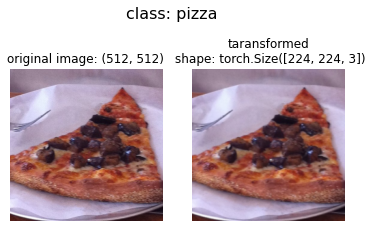

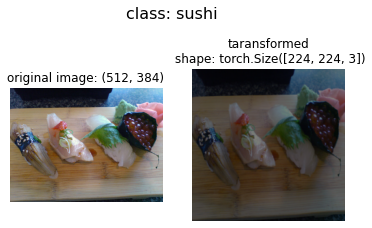

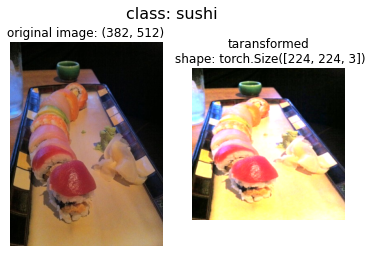

In [ ]:
#plot a random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,seed=42)


#7.0  : Tiny VGG without data augmentation

- replicating the tinyVGG architecture  from the cnn explainer website

###7.1 :Creating transforms and loading data for model 0

In [ ]:
#create a simple transform
simple_transform =transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
#Load and transform data
from torchvision import datasets
train_data_simple=datasets.ImageFolder(root=train_dir,
                                       transform=simple_transform)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=simple_transform)
#tirn the data into dataloaders
import os
from torch.utils.data import DataLoader
#setup the batch size and num of workers
BATCH_SIZE=32
NUM_WORKERS =os.cpu_count()
#create  Dataloaders
train_dataloader_simple =DataLoader(dataset=train_data_simple,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)
test_dataloader_simple=DataLoader(dataset=test_data_simple,batch_size=BATCH_SIZE,shuffle=False,num_workers=NUM_WORKERS)

###7.2 Create the inyVGG model

In [ ]:
class TinyVGG(nn.Module):
  """
  Model architecture copying the tynyVGG  from CNN explainer.
  """
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int, )->None:
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(
            in_channels=input_shape,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, 
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value is same as kernel size
    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, 
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value is same as kernel size
    )
    self.conv_block_3=nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3, 
                  stride=1,
                  padding=0
                  ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) #default stride value is same as kernel size
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16,
                  out_features=output_shape)
    )
  def forward(self,x):
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))) 


In [ ]:
torch.manual_seed(42)
model_0= TinyVGG(
    input_shape=3, #number of color channel
    hidden_units=10,
    output_shape=len(class_names)
).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=3, bias=True)
  )
)

###7.3 try a forward pass on a single image 

In [ ]:
#get a single image batch
image_batch, label_batch=next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape 

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
#try a forward batch
model_0(image_batch.to(device))

tensor([[0.0317, 0.0389, 0.0127],
        [0.0315, 0.0387, 0.0127],
        [0.0315, 0.0391, 0.0127],
        [0.0315, 0.0389, 0.0126],
        [0.0316, 0.0390, 0.0128],
        [0.0317, 0.0390, 0.0125],
        [0.0317, 0.0392, 0.0126],
        [0.0317, 0.0391, 0.0125],
        [0.0320, 0.0387, 0.0127],
        [0.0316, 0.0391, 0.0126],
        [0.0315, 0.0390, 0.0126],
        [0.0315, 0.0389, 0.0126],
        [0.0318, 0.0389, 0.0124],
        [0.0316, 0.0391, 0.0127],
        [0.0319, 0.0395, 0.0126],
        [0.0315, 0.0387, 0.0127],
        [0.0316, 0.0390, 0.0126],
        [0.0316, 0.0390, 0.0126],
        [0.0317, 0.0391, 0.0125],
        [0.0315, 0.0390, 0.0124],
        [0.0316, 0.0392, 0.0126],
        [0.0317, 0.0390, 0.0126],
        [0.0314, 0.0391, 0.0125],
        [0.0318, 0.0388, 0.0130],
        [0.0315, 0.0389, 0.0125],
        [0.0315, 0.0387, 0.0126],
        [0.0314, 0.0390, 0.0126],
        [0.0316, 0.0387, 0.0126],
        [0.0315, 0.0387, 0.0126],
        [0.031

###7.4 use `torchinfo` to get an idea of the shapes going through our model

In [ ]:
#install torchinfo then import it if its available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0,input_size=[1,3,64,64])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 31, 31]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 62, 62]           910
│    └─ReLU: 2-4                         [1, 10, 62, 62]           --
│    └─MaxPool2d: 2-5                    [1, 10, 31, 31]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 29, 29]           910
│    └─ReLU: 2-7                         [1, 10, 29, 29]           --
│    └─Conv2d: 2-8                       [1, 10, 27, 27]           910
│    └─ReLU: 2-9                         [1, 10, 27, 27]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

###7.5 create train and test loops functions
* `train_step()` takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` takes in a model and dataloader and evaluates the model on the dataloader

In [ ]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=30, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1021 | train_acc: 0.2773 | test_loss: 1.1012 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.1008 | train_acc: 0.2734 | test_loss: 1.0910 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.1020 | train_acc: 0.3047 | test_loss: 1.0984 | test_acc: 0.2282
Epoch: 4 | train_loss: 1.0973 | train_acc: 0.3672 | test_loss: 1.0988 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.0573 | train_acc: 0.4648 | test_loss: 1.0271 | test_acc: 0.3419
Total training time: 14.032 seconds


###7.8 Plot the loss curves of model0
a loss curve is a way of tracking your models progress over time.


In [ ]:
# get the model 0 model keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [ ]:
def plot_loss_curves(results:Dict[str,List[float]]):
  """
      plots a training curves of a results dictionary.
  """
  #get the loss values of the results dictionary(training and test)
  loss=results["train_loss"]
  test_loss=results["test_loss"]

  #get the accuracy of the results dictionary (training and test)
  accuracy=results["train_acc"]
  test_accuracy=results["test_acc"]

  #figure out how many epochs there were
  epochs=range(len(results["train_loss"]))
  #setup a plot 
  plt.figure(figsize=(15,7))
  #plot the loss
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss") 
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #plot the accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy,label="train_accuracy")
  plt.plot(epochs,test_accuracy,label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

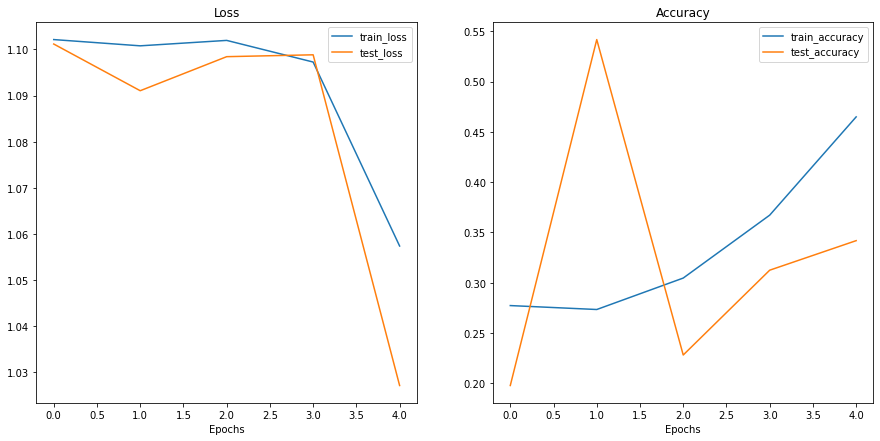

In [ ]:
plot_loss_curves(model_0_results)

#8. what should an ideal loss curve look like  ?
A loss curve is one of the most helpful ways to troubleshoot a model
##8.1 Create a transform with data augmentation

In [ ]:
#create a training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
                                        transforms.Resize(size=(64,64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                             transforms.ToTensor()
                                             ])
test_transform_simple=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

#Create Train and Test `Datasets` and `Dataloaders` with augmentation

In [ ]:
#Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)
test_data_simple=datasets.ImageFolder(root=test_dir,
                                      transform=test_transform_simple)

In [ ]:
#turn our datasets into Dataloaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(
    dataset=train_data_augmented,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)
test_dataloader_simple=DataLoader(
    dataset=test_data_simple,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS
)


#9.3Construct and train model 1
this time we'll be using the same model architectureexcept this timewe've augmented the training data

In [ ]:
#create model_1 and send it to the target device
torch.manual_seed(42)
model_1 =TinyVGG(input_shape=3,hidden_units=20,output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=3, bias=True)
  )
)

Wonderful , nowwe've got a model and dataloaders lets create a loss function and optimizer and call upon our `train()` functionand train and evaluate our model

In [ ]:
#set the random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#set the number of epochs
NUM_EPOCHS=5
#setup a loss function and an optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer =torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001
                            )
#Start a timer
from timeit import default_timer as timer
start_time= timer()

#train model 1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        )
#end the timerand print how it looks
end_time=timer()
print(f"total training time for model_1 : {end_time-start_time:.2f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0947 | train_acc: 0.4258 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0914 | train_acc: 0.4258 | test_loss: 1.1090 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0887 | train_acc: 0.4258 | test_loss: 1.1118 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1039 | train_acc: 0.3047 | test_loss: 1.1140 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0859 | train_acc: 0.4258 | test_loss: 1.1208 | test_acc: 0.2604
total training time for model_1 : 10.88 seconds


##9.4 Plot the loss curves of model 1
a loss curve helps you evaluate  your model performance over time

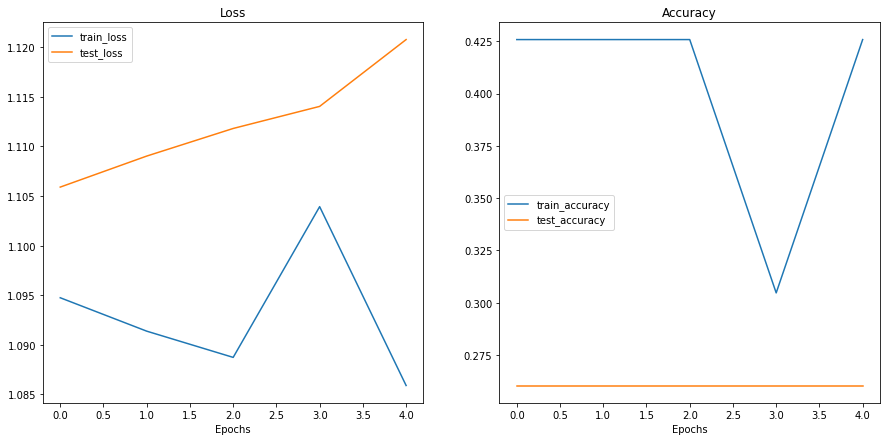

In [ ]:
plot_loss_curves(model_1_results)

##10 comparing our model results
 After evaluating our modeling  experiments on their own, its important to compare them to each other.
 There is few different ways to do this:
 1. Hard coding, this is what we are doing 
 2. Pytorch+ tensorboard
 3. Weights and biases
 4. ML flow

In [ ]:
import pandas as pd
model_0_df=pd.DataFrame(model_0_results)
model_1_df=pd.DataFrame(model_1_results)
model_0_df


,train_loss,train_acc,test_loss,test_acc
0,1.102137,0.277344,1.101173,0.197917
1,1.100781,0.273438,1.091041,0.541667
2,1.101958,0.304688,1.098428,0.228220
3,1.097262,0.367188,1.098834,0.312500
4,1.057348,0.464844,1.027085,0.341856


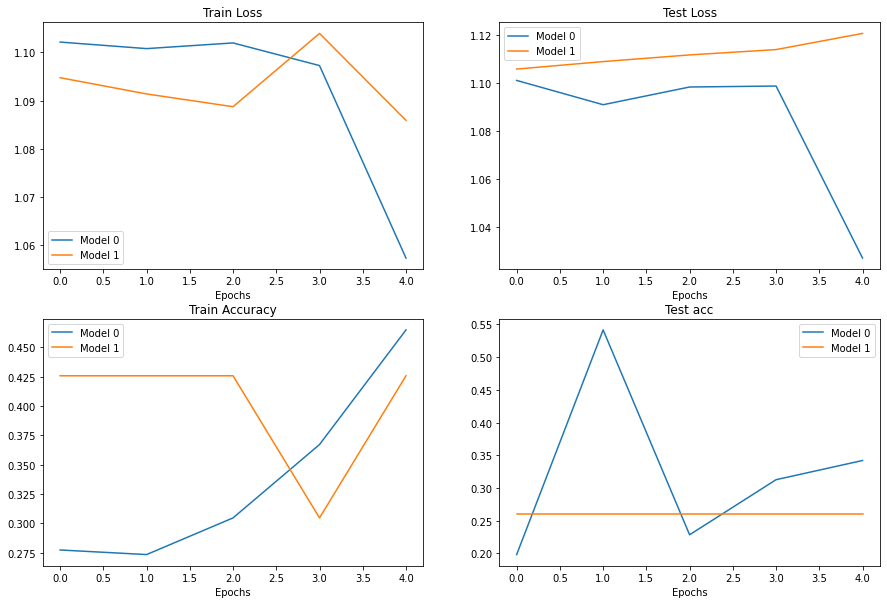

In [ ]:
#setup a plot
plt.figure(figsize=(15,10)) 

#"get a number of epochs"
epochs=range(len(model_0_df))

#plot train loss
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

#plot test loss
plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()


#plot train acc

plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

#plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend()



#11. Making prediction on a custom image
Although we've trained a model on a custom data , how do you make prediction on a sample/image thats not in either the training or testing datasets

In [ ]:
#Download a custom image
import requests
#setup a custom image path
custom_image_path=data_path/"04-pizza-dad.jpeg"
#dwnload the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:
    #when downloading from github we need to use the raw file link
    request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists skipping download")

### 11.1 Loaading in a custom image with pytorch
We have to make sure our custom image is in the same format as the data our model was trained on.
* in Tensor format with dataype (torch.float32)
* of shape 64x64x3
* on the right device

In [ ]:
import torchvision
#read in custom image
custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image Tensor : \n {custom_image_unit8}")
print(f'custom image shape {custom_image_unit8.shape}')
print(f"Custom image datatype : {custom_image_unit8.shape}")

Custom image Tensor : 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
custom image shape torch.Size([3, 4032, 3024])
Custom image dat

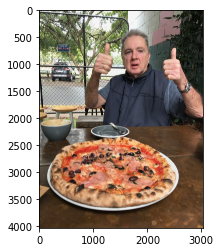

In [ ]:
plt.imshow(custom_image_unit8.permute(1,2,0))

## 11.2 Making a prediction on a custom Image with a trained pytorch model

In [ ]:
#try and make a prediction on an image in unit8 format
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_unit8.to(device))


RuntimeError: ignored

In [ ]:
#load in the custom image and turn it to torch.float32
custom_image=torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

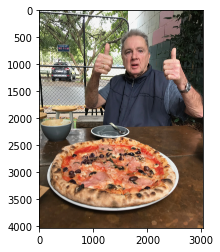

In [ ]:
plt.imshow(custom_image.permute(1,2,0))

In [ ]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))


RuntimeError: ignored

In [ ]:
#create a transform pipeline to resize image
from torchvision import transforms
custom_image_transform=transforms.Compose([
    transforms.Resize(size=(64,64))
])
#transform target image
custom_image_transformed=custom_image_transform(custom_image)
#print out the shapes
print(f'Original shape : {custom_image.shape}')
print(f'transformed shape : {custom_image_transformed.shape}')

Original shape : torch.Size([3, 4032, 3024])
transformed shape : torch.Size([3, 64, 64])


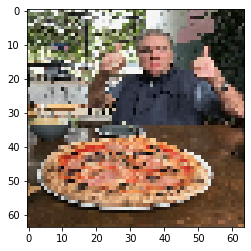

In [ ]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [ ]:
#we have to add a batch size in the first , so we have to unsqueeze it
model_1.eval()
with torch.inference_mode():
  custom_image_pred=model_1(custom_image_transformed.unsqueeze(0).to(device))

custom_image_pred

tensor([[ 0.0694, -0.0397, -0.1082]], device='cuda:0')

Note: to make a predictions on a custom image we had to : 
* Load the image and turn it to tensor
* make sure the image was the same datatype as the model(torch.float32)
* make sure the image was the same shape the data the model was trained (3,64,64) with a batch size (1,3,64,64)
* Make sure the image was on the same device as our model

In [ ]:
#convert logits to prediction labels -probs first-
custom_image_pred_probs=torch.softmax(custom_image_pred,dim=1)
custom_image_pred_probs

tensor([[0.3658, 0.3280, 0.3063]], device='cuda:0')

In [ ]:
#convert prediction probabilities to prediction labels
custom_image_pred_label =torch.argmax(custom_image_pred_probs,dim=1).cpu()
custom_image_pred_label

tensor([0])

In [ ]:
class_names[custom_image_pred_label]

'pizza'

##11.3 Putting custom image prediction together : building a function
ideal outcome: 

A function where we pass an image and have our model predictionon that image and plot the image + prediction

In [ ]:
def pred_and_plot_image(
    model:torch.nn.Module,
    image_path:str,
    class_names: List[str]=None,
    transform=None,
    device=device):
  """
      Makes a prediction on a target image with a trained model and plots the image and prediction.
  """
  #load in the image
  target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)
  #devide the image pixel values by 255 toget them between 0-1
  target_image/=255
  #Transform if necessary
  if transform:
    target_image=transform(target_image) 
  #make sure the model on the target device
  model.to(device)
  #turn on eval inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    #Add an extra dimension to the image (this is the batch dimension)
    target_image=target_image.unsqueeze(0)
    #make a prediction  on the image with an extra dimension
    target_image_pred=model(target_image.to(device)) #make sure the target image is on the right device
    #convert logits -> prediction probabilities
    target_image_pred_probs= torch.softmax(target_image_pred,dim=1)
    #convert prediction probs to prediction labels
    target_image_pred_label= torch.argmax(target_image_pred_probs,dim=1)
    #plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze(0).permute(1,2,0)) #remove batch dim and rearrange shape
    if class_names:
      title=f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
      title=f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

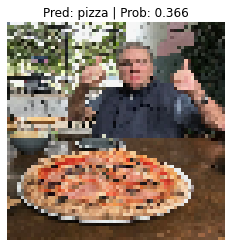

In [ ]:
#pred on our customimage
pred_and_plot_image(
    model=model_1,
    image_path=custom_image_path,
    class_names=class_names, 
    transform=custom_image_transform,
    device=device
)